# 사전 학습된 CNN(VGG-16)을 이용한 Feature Extraction

VGG-16 Model
* University of Oxford - Visual Geometry Group
* 2014 ILSVRC 2nd Model
* ImageNet Large Scale Visual Recognition Challenge (ILSVRC)

In [1]:
import warnings
warnings.filterwarnings('ignore')

* Import TensorFlow

In [2]:
import tensorflow as tf
tf.__version__

'2.12.0'

# I. wget From Github

* 'dogs_and_cats_small.zip' 파일 다운로드

In [3]:
!wget https://raw.githubusercontent.com/rusita-ai/pyData/master/dogs_and_cats_small.zip

--2023-04-05 01:45:27--  https://raw.githubusercontent.com/rusita-ai/pyData/master/dogs_and_cats_small.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90618980 (86M) [application/zip]
Saving to: ‘dogs_and_cats_small.zip’

dogs_and_cats_small 100%[===================>]  86.42M   388MB/s    in 0.2s    

2023-04-05 01:45:31 (388 MB/s) - ‘dogs_and_cats_small.zip’ saved [90618980/90618980]



* 다운로드 결과 확인

In [4]:
!ls -l

total 88500
-rw-r--r-- 1 root root 90618980 Apr  5 01:45 dogs_and_cats_small.zip
drwxr-xr-x 1 root root     4096 Apr  3 13:38 sample_data


# II. Data Preprocessing

> ## 1) Unzip 'dogs_and_cats_small.zip'

In [5]:
!unzip -q /content/dogs_and_cats_small.zip

* 학습 데이터 확인

In [6]:
!ls -l

total 88512
-rw-r--r-- 1 root root 90618980 Apr  5 01:45 dogs_and_cats_small.zip
drwxr-xr-x 1 root root     4096 Apr  3 13:38 sample_data
drwxr-xr-x 4 root root     4096 Apr  5 01:45 test
drwxr-xr-x 4 root root     4096 Apr  5 01:45 train
drwxr-xr-x 4 root root     4096 Apr  5 01:45 validation


> ## 2) Image_File Directory Setting

* train_dir
* valid_dir
* test_dir

In [7]:
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test'

# III. Import VGG-16 Model

> ## 1) conv_base

In [8]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

58889256/58889256 [==============================] - 2s 0us/step


> ## 2) Model Information

In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# IV. Feature Extraction

> ## 1) 특징추출 함수 정의 : extract_feature( )

* conv_base.predict( )

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20
def extract_features(directory, sample_count):
  features = np.zeros(shape = (sample_count, 4, 4, 512))
  labels = np.zeros(shape = (sample_count))
  
  generator = datagen.flow_from_directory(directory,
                                          target_size = (150, 150),
                                          batch_size = batch_size,
                                          class_mode = 'binary')
  
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch, verbose = 0)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

> ## 2) 특징추출 함수 적용

* train_dir
* valid_dir
* test_dir

In [11]:
%%time
train_features, train_labels = extract_features(train_dir, 2000)
valid_features, valid_labels = extract_features(valid_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
CPU times: user 36.5 s, sys: 1.73 s, total: 38.3 s
Wall time: 47.7 s


In [12]:
train_features.shape, valid_features.shape, test_features.shape

((2000, 4, 4, 512), (1000, 4, 4, 512), (1000, 4, 4, 512))

> ## 3) Reshape Features

* For 'Classification' Network

In [14]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
valid_features = np.reshape(valid_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

train_features.shape, valid_features.shape, test_features.shape

((2000, 8192), (1000, 8192), (1000, 8192))

# V. Keras DNN Modeling with VGG-16 Featured Data

> ## 1) Model Define

* 'Classification' Network Only
* Dropout Layer

In [15]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


> ## 2) Model Compile

* 모델 학습방법 설정

In [17]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

> ## 3) Model Fit

In [18]:
%%time
Hist_dandc = model.fit( train_features, train_labels,
                        epochs = 100,
                        batch_size = 20,
                        validation_data = (valid_features, valid_labels))

Epoch 1/100
100/100 [==============================] - 3s 6ms/step - loss: 0.4928 - accuracy: 0.7965 - val_loss: 0.2673 - val_accuracy: 0.8900
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.2641 - accuracy: 0.8870 - val_loss: 0.2414 - val_accuracy: 0.8980
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.2076 - accuracy: 0.9155 - val_loss: 0.2388 - val_accuracy: 0.9020
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1720 - accuracy: 0.9305 - val_loss: 0.2462 - val_accuracy: 0.8970
Epoch 5/100
100/100 [==============================] - 0s 4ms/step - loss: 0.1405 - accuracy: 0.9425 - val_loss: 0.2586 - val_accuracy: 0.8950
Epoch 6/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0984 - accuracy: 0.9615 - val_loss: 0.2703 - val_accuracy: 0.8980
Epoch 7/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0890 - accuracy: 0.9685 - val_loss: 0.2633 - val_accuracy: 0.8990

> ## 4) 학습 결과 시각화

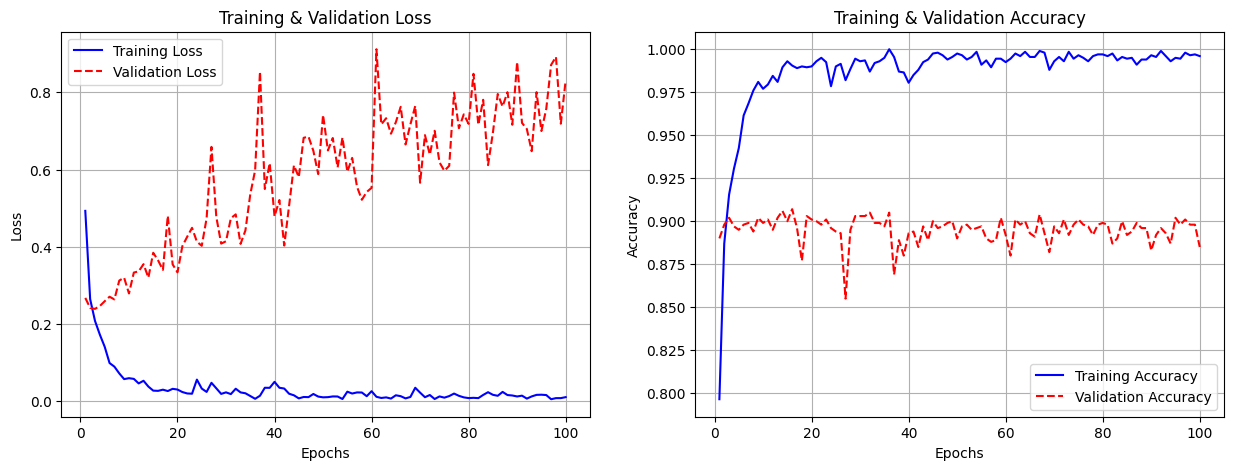

In [19]:
import matplotlib.pyplot as plt
epochs = range(1, len(Hist_dandc.history['loss']) + 1)
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, Hist_dandc.history['loss'], 'b-')
plt.plot(epochs, Hist_dandc.history['val_loss'], 'r--')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(epochs, Hist_dandc.history['accuracy'], 'b-')
plt.plot(epochs, Hist_dandc.history['val_accuracy'], 'r--')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

> ## 5) Model Evaluate

* Loss & Accuracy

In [20]:
loss, accuracy = model.evaluate(test_features, test_labels, verbose = 0)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

Loss = 0.93438
Accuracy = 0.87200
